# Description

The notebooks performs comparison between bid-ask data loaded from `"v1_0_0"`and `"v2_0_0"` data versions.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging

import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.ccxt.data.client as icdcl
import im_v2.common.universe as ivcu
import market_data.market_data_example as mdmadaex

/app/amp/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-edeb1763-51b0-46d5-a53b-90aaf9a65b70.json'
INFO  # Git
  branch_name='CmTask7333_Compare_liquidity_metrics_from_columns_and_computed'
  hash='ad2b8b74c'
  # Last commits:
    *   ad2b8b74c Dan      Merge branch 'master' into CmTask7333_Compare_liquidity_metrics_from_columns_and_computed (77 minutes ago) Thu May 9 16:29:02 2024  (HEAD -> CmTask7333_Compare_liquidity_metrics_from_columns_and_computed, origin/CmTask7333_Compare_liquidity_metrics_from_columns_and_computed)
    |\  
    | * b4b1a3098 Vedanshu Joshi CmTask8227 Update monitoring docs for shadow trading (#8231)      (   2 hours ago) Thu May 9 15:38:22 2024  (origin/master, origin/HEAD, master)
    * | 2191e4be5 Dan      Merge branch 'master' into CmTask7333_Compare_liquidity_metrics_from_columns_and_computed (   3 hours ago) Thu May 9 15:03:41 2024           
    |\| 
# Machine info
  system=Linux
  node name=e8318

# Config

In [4]:
universe_version = "v8"
wall_clock_time = pd.Timestamp("2100-01-01T00:00:00+00:00")
config = {
    "universe": {
        "vendor": "CCXT",
        "mode": "trade",
        "version": universe_version,
        "as_full_symbol": True,
    },
    "US_equities_tz": "America/New_York",
    "bid_ask_data": {
        "start_timestamp": pd.Timestamp("2024-01-31T00:00:00+00:00"),
        "end_timestamp": pd.Timestamp("2024-02-19T00:00:00+00:00"),
        "column_names": {
            "timestamp": "timestamp",
        },
        "im_client_config_v1": {
            "universe_version": "v8",
            "root_dir": "s3://cryptokaizen-data-test/v3",
            "partition_mode": "by_year_month",
            "dataset": "bid_ask",
            "contract_type": "futures",
            "data_snapshot": "",
            "version": "v1_0_0",
            "download_universe_version": "v8",
            "tag": "resampled_1min",
            "aws_profile": "ck",
        },
        "market_data_config_v1": {
            "columns": [
                "level_1.bid_price.open",
                "level_1.bid_price.high",
                "level_1.bid_price.low",
                "level_1.bid_price.close",
                "level_1.bid_price.mean",
                "level_1.bid_size.open",
                "level_1.bid_size.max",
                "level_1.bid_size.min",
                "level_1.bid_size.close",
                "level_1.bid_size.mean",
                "level_1.ask_price.open",
                "level_1.ask_price.high",
                "level_1.ask_price.low",
                "level_1.ask_price.close",
                "level_1.ask_price.mean",
                "level_1.ask_size.open",
                "level_1.ask_size.max",
                "level_1.ask_size.min",
                "level_1.ask_size.close",
                "level_1.ask_size.mean",
                "asset_id",
                "full_symbol",
                "start_ts",
                "knowledge_timestamp",
            ],
            "column_remap": None,
            "wall_clock_time": wall_clock_time,
            "filter_data_mode": "assert",
        },
        "im_client_config_v2": {
            "universe_version": "v8",
            "root_dir": "s3://cryptokaizen-data-test/v3",
            "partition_mode": "by_year_month",
            "dataset": "bid_ask",
            "contract_type": "futures",
            "data_snapshot": "",
            "version": "v2_0_0",
            "download_universe_version": "v8",
            "tag": "resampled_1min",
            "aws_profile": "ck",
        },
        "market_data_config_v2": {
            "columns": cofinanc.get_bid_ask_columns_by_level(1)
            + ["asset_id", "full_symbol", "start_ts", "knowledge_timestamp"],
            "column_remap": None,
            "wall_clock_time": wall_clock_time,
            "filter_data_mode": "assert",
        },
        "column_names": {
            "timestamp": "timestamp",
            "full_symbol": "full_symbol",
            "close": "close",
            "volume": "volume",
            "volume_notional": "volume_notional",
            "ask_price": "level_1.ask_price.close",
            "bid_price": "level_1.bid_price.close",
            "bid_ask_midpoint": "level_1.bid_ask_midpoint.close",
            "half_spread": "level_1.half_spread.close",
        },
        "rolling_window": 30,
    },
    "liquidity_metrics": {
        "timestamp": "timestamp",
        "full_symbol": "full_symbol",
        "close": "close",
        "volume": "volume",
        "volume_notional": "volume_notional",
        "ask_price": "level_1.ask_price.close",
        "bid_price": "level_1.bid_price.close",
        "half_spread_bps_mean": "half_spread_bps_mean",
        "ask_vol_bps_mean": "ask_vol_bps_mean",
        "bid_vol_bps_mean": "bid_vol_bps_mean",
        "bid_vol_to_half_spread_mean": "bid_vol_to_half_spread_mean",
        "bid_vol_to_half_spread_bucket": "bid_vol_to_half_spread_bucket",
        "half_spread_bucket": "half_spread_bucket",
    },
}
config = cconfig.Config().from_dict(config)
print(config)

universe: 
  vendor: CCXT
  mode: trade
  version: v8
  as_full_symbol: True
US_equities_tz: America/New_York
bid_ask_data: 
  start_timestamp: 2024-01-31 00:00:00+00:00
  end_timestamp: 2024-02-19 00:00:00+00:00
  column_names: 
    timestamp: timestamp
    full_symbol: full_symbol
    close: close
    volume: volume
    volume_notional: volume_notional
    ask_price: level_1.ask_price.close
    bid_price: level_1.bid_price.close
    bid_ask_midpoint: level_1.bid_ask_midpoint.close
    half_spread: level_1.half_spread.close
  im_client_config_v1: 
    universe_version: v8
    root_dir: s3://cryptokaizen-data-test/v3
    partition_mode: by_year_month
    dataset: bid_ask
    contract_type: futures
    data_snapshot: 
    version: v1_0_0
    download_universe_version: v8
    tag: resampled_1min
    aws_profile: ck
  market_data_config_v1: 
    columns: ['level_1.bid_price.open', 'level_1.bid_price.high', 'level_1.bid_price.low', 'level_1.bid_price.close', 'level_1.bid_price.mean', 'leve

# Universe

In [5]:
# Get full symbol universe.
full_symbols = ivcu.get_vendor_universe(**config["universe"])
_LOG.info("The number of coins in the universe=%s", len(full_symbols))
full_symbols

INFO  The number of coins in the universe=206


['binance::1000FLOKI_USDT',
 'binance::1000LUNC_USDT',
 'binance::1000PEPE_USDT',
 'binance::1000SHIB_USDT',
 'binance::1000XEC_USDT',
 'binance::1INCH_USDT',
 'binance::AAVE_USDT',
 'binance::ACH_USDT',
 'binance::ADA_USDT',
 'binance::AGIX_USDT',
 'binance::AGLD_USDT',
 'binance::ALGO_USDT',
 'binance::ALICE_USDT',
 'binance::ALPHA_USDT',
 'binance::AMB_USDT',
 'binance::ANKR_USDT',
 'binance::APE_USDT',
 'binance::API3_USDT',
 'binance::APT_USDT',
 'binance::ARB_USDT',
 'binance::ARKM_USDT',
 'binance::ARPA_USDT',
 'binance::AR_USDT',
 'binance::ASTR_USDT',
 'binance::ATA_USDT',
 'binance::ATOM_USDT',
 'binance::AUDIO_USDT',
 'binance::AVAX_USDT',
 'binance::AXS_USDT',
 'binance::BAKE_USDT',
 'binance::BAL_USDT',
 'binance::BAND_USDT',
 'binance::BAT_USDT',
 'binance::BCH_USDT',
 'binance::BEL_USDT',
 'binance::BLUEBIRD_USDT',
 'binance::BLUR_USDT',
 'binance::BLZ_USDT',
 'binance::BNB_USDT',
 'binance::BNT_USDT',
 'binance::BNX_USDT',
 'binance::BTCDOM_USDT',
 'binance::BTCST_USDT'

In [6]:
# Get asset ids.
asset_ids = [
    ivcu.string_to_numerical_id(full_symbol) for full_symbol in full_symbols
]
asset_ids

[1759964944,
 2499295598,
 1667142502,
 1165984980,
 4000324056,
 1329043685,
 2147056098,
 1380211661,
 3303714233,
 2824345365,
 6401966539,
 3346251904,
 6868622736,
 1879911319,
 8417396791,
 6552940297,
 6051632686,
 2971863517,
 7870860852,
 5141755262,
 3347884334,
 1614539337,
 1558759887,
 1886236598,
 7926891869,
 2830135149,
 1700068524,
 8717633868,
 2540896331,
 1528092593,
 9924456971,
 2065720081,
 2373191144,
 3304664847,
 4048375177,
 2680899251,
 2057989114,
 3043633751,
 8968126878,
 3211024596,
 2209896697,
 2854684565,
 1446905320,
 1467591036,
 2244079764,
 6756254315,
 1477469377,
 2802770249,
 2896468199,
 8022576759,
 1572068771,
 1457687081,
 1517683944,
 1758730026,
 2260123723,
 1956413759,
 2476706208,
 5608532245,
 3323218445,
 2967633963,
 4106449474,
 2815720524,
 1849079991,
 1432820310,
 1981008462,
 1532542630,
 3065029174,
 1891737434,
 9497104967,
 3401245610,
 4444259905,
 2794251396,
 3207514097,
 1670436375,
 2061507978,
 3323452427,
 1464553467,

# Bid / ask price changes

## `"v1_0_0"`

In [7]:
bid_ask_im_client_v1 = icdcl.ccxt_clients.CcxtHistoricalPqByTileClient(
    **config["bid_ask_data"]["im_client_config_v1"]
)

In [8]:
bid_ask_market_data_v1 = mdmadaex.get_HistoricalImClientMarketData_example1(
    bid_ask_im_client_v1,
    asset_ids,
    **config["bid_ask_data"]["market_data_config_v1"],
)

In [9]:
bid_ask_data_v1 = bid_ask_market_data_v1.get_data_for_interval(
    config["bid_ask_data"]["start_timestamp"],
    config["bid_ask_data"]["end_timestamp"],
    config["bid_ask_data"]["column_names"]["timestamp"],
    asset_ids,
)
# Convert to ET to be able to compare with US equities active trading hours.
bid_ask_data_v1.index = bid_ask_data_v1.index.tz_convert(config["US_equities_tz"])
hpandas.df_to_str(bid_ask_data_v1, num_rows=5, log_level=logging.INFO)

WARNING * Failed assertion *
val1 - val2=['binance::BTCST_USDT', 'binance::BTS_USDT', 'binance::COCOS_USDT', 'binance::CVC_USDT', 'binance::FTT_USDT', 'binance::HNT_USDT', 'binance::RAY_USDT', 'binance::SC_USDT', 'binance::SRM_USDT', 'binance::TOMO_USDT']
val2 - val1=[]
val1=206 [binance::1000FLOKI_USDT, ... binance::ZRX_USDT]
set eq
val2=196 [binance::1000FLOKI_USDT, ... binance::ZRX_USDT]
Not all the requested symbols were retrieved
Continuing as per user request with only_warning=True


,asset_id,full_symbol,level_1.bid_price.open,level_1.bid_price.high,level_1.bid_price.low,level_1.bid_price.close,level_1.bid_price.mean,level_1.bid_size.open,level_1.bid_size.max,level_1.bid_size.min,level_1.bid_size.close,level_1.bid_size.mean,level_1.ask_price.open,level_1.ask_price.high,level_1.ask_price.low,level_1.ask_price.close,level_1.ask_price.mean,level_1.ask_size.open,level_1.ask_size.max,level_1.ask_size.min,level_1.ask_size.close,level_1.ask_size.mean,knowledge_timestamp,start_ts
2024-01-30 19:00:00-05:00,1020313424,binance::OP_USDT,3.1611,3.1611,3.1546,3.156,3.156776,12.8,1506.5,2.1,150.0,235.868539,3.1612,3.1612,3.1547,3.1561,3.156884,82.2,3982.3,0.3,2.2,610.073408,2024-01-31 04:34:02.605670+00:00,2024-01-30 18:59:00-05:00
2024-01-30 19:00:00-05:00,1030828978,binance::GMT_USDT,0.2638,0.2638,0.2634,0.2635,0.263544,33315.0,77146.0,20.0,32611.0,26083.493976,0.2639,0.2639,0.2635,0.2636,0.263644,57448.0,107186.0,95.0,31566.0,46856.11245,2024-01-31 04:34:02.605670+00:00,2024-01-30 18:59:00-05:00
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-18 18:59:00-05:00,9891918887,binance::YFI_USDT,7748.0,7749.0,7747.0,7747.0,7747.728571,0.095,0.135,0.001,0.027,0.039893,7749.0,7750.0,7748.0,7748.0,7748.728571,0.021,0.201,0.007,0.007,0.035021,2024-02-19 04:33:18.540809+00:00,2024-02-18 18:58:00-05:00
2024-02-18 18:59:00-05:00,9924456971,binance::BAL_USDT,4.187,4.187,4.184,4.185,4.185223,47.4,215.1,3.9,20.8,63.001351,4.188,4.188,4.185,4.186,4.186304,31.7,308.3,7.5,75.8,54.241216,2024-02-19 04:33:18.540809+00:00,2024-02-18 18:58:00-05:00


In [10]:
# Set input parameters.
rolling_window = config["bid_ask_data"]["rolling_window"]
full_symbol_col = config["bid_ask_data"]["column_names"]["full_symbol"]
ask_price_col = config["bid_ask_data"]["column_names"]["ask_price"]
bid_price_col = config["bid_ask_data"]["column_names"]["bid_price"]
# Get ask and bid prices for all instruments.
ask_price_df_v1 = bid_ask_data_v1.pivot(
    columns=full_symbol_col, values=ask_price_col
)
bid_price_df_v1 = bid_ask_data_v1.pivot(
    columns=full_symbol_col, values=bid_price_col
)

In [11]:
bid_ask_midpoint_df_v1 = 0.5 * (ask_price_df_v1 + bid_price_df_v1)
half_spread_df_v1 = (
    0.5 * (ask_price_df_v1 - bid_price_df_v1) / bid_ask_midpoint_df_v1
)
half_spread_bps_df_v1 = 1e4 * half_spread_df_v1
hpandas.df_to_str(half_spread_bps_df_v1, log_level=logging.INFO)

full_symbol,binance::1000FLOKI_USDT,binance::1000LUNC_USDT,binance::1000PEPE_USDT,binance::1000SHIB_USDT,binance::1000XEC_USDT,binance::1INCH_USDT,binance::AAVE_USDT,binance::ACH_USDT,binance::ADA_USDT,binance::AGIX_USDT,binance::AGLD_USDT,binance::ALGO_USDT,binance::ALICE_USDT,binance::ALPHA_USDT,binance::AMB_USDT,binance::ANKR_USDT,binance::APE_USDT,binance::API3_USDT,binance::APT_USDT,binance::ARB_USDT,binance::ARKM_USDT,binance::ARPA_USDT,binance::AR_USDT,binance::ASTR_USDT,binance::ATA_USDT,binance::ATOM_USDT,binance::AUDIO_USDT,binance::AVAX_USDT,binance::AXS_USDT,binance::BAKE_USDT,binance::BAL_USDT,binance::BAND_USDT,binance::BAT_USDT,binance::BCH_USDT,binance::BEL_USDT,binance::BLUEBIRD_USDT,binance::BLUR_USDT,binance::BLZ_USDT,binance::BNB_USDT,binance::BNT_USDT,binance::BNX_USDT,binance::BTCDOM_USDT,binance::BTC_USDT,binance::C98_USDT,binance::CELO_USDT,binance::CELR_USDT,binance::CFX_USDT,binance::CHR_USDT,binance::CHZ_USDT,binance::CKB_USDT,binance::COMBO_USDT,binance::COMP_USDT,binance::COTI_USDT,binance::CRV_USDT,binance::CTSI_USDT,binance::CVX_USDT,binance::CYBER_USDT,binance::DAR_USDT,binance::DASH_USDT,binance::DEFI_USDT,binance::DENT_USDT,binance::DODOX_USDT,binance::DOGE_USDT,binance::DOT_USDT,binance::DUSK_USDT,binance::DYDX_USDT,binance::EDU_USDT,binance::EGLD_USDT,binance::ENJ_USDT,binance::ENS_USDT,binance::EOS_USDT,binance::ETC_USDT,binance::ETH_USDT,binance::FET_USDT,binance::FIL_USDT,binance::FLM_USDT,binance::FLOW_USDT,binance::FOOTBALL_USDT,binance::FTM_USDT,binance::FXS_USDT,binance::GALA_USDT,binance::GAL_USDT,binance::GMT_USDT,binance::GMX_USDT,binance::GRT_USDT,binance::GTC_USDT,binance::HBAR_USDT,binance::HFT_USDT,binance::HIFI_USDT,binance::HIGH_USDT,binance::HOOK_USDT,binance::HOT_USDT,binance::ICP_USDT,binance::ICX_USDT,binance::IDEX_USDT,binance::ID_USDT,binance::IMX_USDT,binance::INJ_USDT,binance::IOST_USDT,binance::IOTA_USDT,binance::IOTX_USDT,binance::JASMY_USDT,binance::JOE_USDT,binance::KAVA_USDT,binance::KEY_USDT,binance::KLAY_USDT,binance::KNC_USDT,binance::KSM_USDT,binance::LDO_USDT,binance::LEVER_USDT,binance::LINA_USDT,binance::LINK_USDT,binance::LIT_USDT,binance::LPT_USDT,binance::LQTY_USDT,binance::LRC_USDT,binance::LTC_USDT,binance::LUNA2_USDT,binance::MAGIC_USDT,binance::MANA_USDT,binance::MASK_USDT,binance::MATIC_USDT,binance::MAV_USDT,binance::MDT_USDT,binance::MINA_USDT,binance::MKR_USDT,binance::MTL_USDT,binance::NEAR_USDT,binance::NEO_USDT,binance::NKN_USDT,binance::NMR_USDT,binance::OCEAN_USDT,binance::OGN_USDT,binance::OMG_USDT,binance::ONE_USDT,binance::ONT_USDT,binance::OP_USDT,binance::OXT_USDT,binance::PENDLE_USDT,binance::PEOPLE_USDT,binance::PERP_USDT,binance::PHB_USDT,binance::QNT_USDT,binance::QTUM_USDT,binance::RAD_USDT,binance::RDNT_USDT,binance::REEF_USDT,binance::REN_USDT,binance::RLC_USDT,binance::RNDR_USDT,binance::ROSE_USDT,binance::RSR_USDT,binance::RUNE_USDT,binance::RVN_USDT,binance::SAND_USDT,binance::SEI_USDT,binance::SFP_USDT,binance::SKL_USDT,binance::SNX_USDT,binance::SOL_USDT,binance::SPELL_USDT,binance::SSV_USDT,binance::STG_USDT,binance::STMX_USDT,binance::STORJ_USDT,binance::STX_USDT,binance::SUI_USDT,binance::SUSHI_USDT,binance::SXP_USDT,binance::THETA_USDT,binance::TLM_USDT,binance::TRB_USDT,binance::TRU_USDT,binance::TRX_USDT,binance::T_USDT,binance::UMA_USDT,binance::UNFI_USDT,binance::UNI_USDT,binance::USDC_USDT,binance::VET_USDT,binance::WAVES_USDT,binance::WLD_USDT,binance::WOO_USDT,binance::XEM_USDT,binance::XLM_USDT,binance::XMR_USDT,binance::XRP_USDT,binance::XTZ_USDT,binance::XVG_USDT,binance::XVS_USDT,binance::YFI_USDT,binance::YGG_USDT,binance::ZEC_USDT,binance::ZEN_USDT,binance::ZIL_USDT,binance::ZRX_USDT
2024-01-30 19:00:00-05:00,1.749781,0.512007,0.495368,0.552639,1.630523,1.217582,0.537779,2.580645,0.973236,1.823819,1.749016,3.03859,4.411116,0.515225,1.302762,2.05719,3.497726,0.167935,0.551481,0.265358,0.89214,0.797512,1.70911,0.279181,5.698006,0.53166,2.678811,0.141991,0.680318,1.457089,1.343905,0.296762,2.240645,0.210682,1.

In [12]:
half_spread_bps_mean_v1 = half_spread_bps_df_v1.mean().sort_values()
half_spread_bps_mean_v1.name = config["liquidity_metrics"]["half_spread_bps_mean"]

In [13]:
bid_vol_df_v1 = bid_price_df_v1.ffill().pct_change().rolling(rolling_window).std()
bid_vol_bps_df_v1 = 1e4 * bid_vol_df_v1

In [14]:
bid_vol_to_half_spread_v1 = bid_vol_bps_df_v1.divide(half_spread_bps_df_v1)
hpandas.df_to_str(bid_vol_to_half_spread_v1, log_level=logging.INFO)

full_symbol,binance::1000FLOKI_USDT,binance::1000LUNC_USDT,binance::1000PEPE_USDT,binance::1000SHIB_USDT,binance::1000XEC_USDT,binance::1INCH_USDT,binance::AAVE_USDT,binance::ACH_USDT,binance::ADA_USDT,binance::AGIX_USDT,binance::AGLD_USDT,binance::ALGO_USDT,binance::ALICE_USDT,binance::ALPHA_USDT,binance::AMB_USDT,binance::ANKR_USDT,binance::APE_USDT,binance::API3_USDT,binance::APT_USDT,binance::ARB_USDT,binance::ARKM_USDT,binance::ARPA_USDT,binance::AR_USDT,binance::ASTR_USDT,binance::ATA_USDT,binance::ATOM_USDT,binance::AUDIO_USDT,binance::AVAX_USDT,binance::AXS_USDT,binance::BAKE_USDT,binance::BAL_USDT,binance::BAND_USDT,binance::BAT_USDT,binance::BCH_USDT,binance::BEL_USDT,binance::BLUEBIRD_USDT,binance::BLUR_USDT,binance::BLZ_USDT,binance::BNB_USDT,binance::BNT_USDT,binance::BNX_USDT,binance::BTCDOM_USDT,binance::BTC_USDT,binance::C98_USDT,binance::CELO_USDT,binance::CELR_USDT,binance::CFX_USDT,binance::CHR_USDT,binance::CHZ_USDT,binance::CKB_USDT,binance::COMBO_USDT,binance::COMP_USDT,binance::COTI_USDT,binance::CRV_USDT,binance::CTSI_USDT,binance::CVX_USDT,binance::CYBER_USDT,binance::DAR_USDT,binance::DASH_USDT,binance::DEFI_USDT,binance::DENT_USDT,binance::DODOX_USDT,binance::DOGE_USDT,binance::DOT_USDT,binance::DUSK_USDT,binance::DYDX_USDT,binance::EDU_USDT,binance::EGLD_USDT,binance::ENJ_USDT,binance::ENS_USDT,binance::EOS_USDT,binance::ETC_USDT,binance::ETH_USDT,binance::FET_USDT,binance::FIL_USDT,binance::FLM_USDT,binance::FLOW_USDT,binance::FOOTBALL_USDT,binance::FTM_USDT,binance::FXS_USDT,binance::GALA_USDT,binance::GAL_USDT,binance::GMT_USDT,binance::GMX_USDT,binance::GRT_USDT,binance::GTC_USDT,binance::HBAR_USDT,binance::HFT_USDT,binance::HIFI_USDT,binance::HIGH_USDT,binance::HOOK_USDT,binance::HOT_USDT,binance::ICP_USDT,binance::ICX_USDT,binance::IDEX_USDT,binance::ID_USDT,binance::IMX_USDT,binance::INJ_USDT,binance::IOST_USDT,binance::IOTA_USDT,binance::IOTX_USDT,binance::JASMY_USDT,binance::JOE_USDT,binance::KAVA_USDT,binance::KEY_USDT,binance::KLAY_USDT,binance::KNC_USDT,binance::KSM_USDT,binance::LDO_USDT,binance::LEVER_USDT,binance::LINA_USDT,binance::LINK_USDT,binance::LIT_USDT,binance::LPT_USDT,binance::LQTY_USDT,binance::LRC_USDT,binance::LTC_USDT,binance::LUNA2_USDT,binance::MAGIC_USDT,binance::MANA_USDT,binance::MASK_USDT,binance::MATIC_USDT,binance::MAV_USDT,binance::MDT_USDT,binance::MINA_USDT,binance::MKR_USDT,binance::MTL_USDT,binance::NEAR_USDT,binance::NEO_USDT,binance::NKN_USDT,binance::NMR_USDT,binance::OCEAN_USDT,binance::OGN_USDT,binance::OMG_USDT,binance::ONE_USDT,binance::ONT_USDT,binance::OP_USDT,binance::OXT_USDT,binance::PENDLE_USDT,binance::PEOPLE_USDT,binance::PERP_USDT,binance::PHB_USDT,binance::QNT_USDT,binance::QTUM_USDT,binance::RAD_USDT,binance::RDNT_USDT,binance::REEF_USDT,binance::REN_USDT,binance::RLC_USDT,binance::RNDR_USDT,binance::ROSE_USDT,binance::RSR_USDT,binance::RUNE_USDT,binance::RVN_USDT,binance::SAND_USDT,binance::SEI_USDT,binance::SFP_USDT,binance::SKL_USDT,binance::SNX_USDT,binance::SOL_USDT,binance::SPELL_USDT,binance::SSV_USDT,binance::STG_USDT,binance::STMX_USDT,binance::STORJ_USDT,binance::STX_USDT,binance::SUI_USDT,binance::SUSHI_USDT,binance::SXP_USDT,binance::THETA_USDT,binance::TLM_USDT,binance::TRB_USDT,binance::TRU_USDT,binance::TRX_USDT,binance::T_USDT,binance::UMA_USDT,binance::UNFI_USDT,binance::UNI_USDT,binance::USDC_USDT,binance::VET_USDT,binance::WAVES_USDT,binance::WLD_USDT,binance::WOO_USDT,binance::XEM_USDT,binance::XLM_USDT,binance::XMR_USDT,binance::XRP_USDT,binance::XTZ_USDT,binance::XVG_USDT,binance::XVS_USDT,binance::YFI_USDT,binance::YGG_USDT,binance::ZEC_USDT,binance::ZEN_USDT,binance::ZIL_USDT,binance::ZRX_USDT
2024-01-30 19:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [15]:
bid_vol_to_half_spread_mean_v1 = bid_vol_to_half_spread_v1.mean().sort_values(
    ascending=False
)
bid_vol_to_half_spread_mean_v1.name = config["liquidity_metrics"][
    "bid_vol_to_half_spread_mean"
]

In [16]:
# Get the vol metric values and put them in a DataFrame.
bid_vol_to_half_spread_mean_df_v1 = bid_vol_to_half_spread_mean_v1.sort_values(
    ascending=False
).to_frame()
# Set buckets' cutpoints and labels.
cutpoints = [-float("inf"), 1, 5, 10, 25, 250, float("inf")]
labels = [
    "(-inf, 1]",
    "(1, 5]",
    "(5, 10]",
    "(10, 25]",
    "(25, 250]",
    "(250, inf)",
]
# Assign buckets to full symbols.
bid_vol_to_half_spread_bucket_v1 = pd.cut(
    bid_vol_to_half_spread_mean_df_v1[
        config["liquidity_metrics"]["bid_vol_to_half_spread_mean"]
    ],
    bins=cutpoints,
    labels=labels,
)
bid_vol_to_half_spread_bucket_v1.name = config["liquidity_metrics"][
    "bid_vol_to_half_spread_bucket"
]
bid_vol_to_half_spread_mean_df_v1 = pd.concat(
    [bid_vol_to_half_spread_mean_df_v1, bid_vol_to_half_spread_bucket_v1], axis=1
)
hpandas.df_to_str(bid_vol_to_half_spread_mean_df_v1, log_level=logging.INFO)

,bid_vol_to_half_spread_mean,bid_vol_to_half_spread_bucket
binance::DUSK_USDT,inf,"(250, inf)"
binance::BTC_USDT,469.619549,"(250, inf)"
binance::ETH_USDT,274.055363,"(250, inf)"
,...,...
binance::EOS_USDT,1.115685,"(1, 5]"
binance::CRV_USDT,0.952509,"(-inf, 1]"
binance::XEM_USDT,0.645854,"(-inf, 1]"


In [17]:
# Get the vol metric values and put them in a DataFrame.
half_spread_bps_mean_df_v1 = half_spread_bps_mean_v1.sort_values().to_frame()
# Set buckets' cutpoints and labels.
cutpoints = [-float("inf"), 0.05, 0.5, 1.0, 2.0, 10.0, float("inf")]
labels = [
    "(-inf, 0.05]",
    "(0.05, 0.5]",
    "(0.5, 1.0]",
    "(1.0, 2.0]",
    "(2.0, 10.0]",
    "(10.0, inf)",
]
# Assign buckets to full symbols.
half_spread_bucket_v1 = pd.cut(
    half_spread_bps_mean_df_v1[
        config["liquidity_metrics"]["half_spread_bps_mean"]
    ],
    bins=cutpoints,
    labels=labels,
)
half_spread_bucket_v1.name = config["liquidity_metrics"]["half_spread_bucket"]
half_spread_bps_mean_df_v1 = pd.concat(
    [half_spread_bps_mean_df_v1, half_spread_bucket_v1], axis=1
)
hpandas.df_to_str(half_spread_bps_mean_df_v1, log_level=logging.INFO)

,half_spread_bps_mean,half_spread_bucket
binance::BTC_USDT,0.011236,"(-inf, 0.05]"
binance::ETH_USDT,0.020421,"(-inf, 0.05]"
binance::SOL_USDT,0.049161,"(-inf, 0.05]"
,...,...
binance::STMX_USDT,7.13406,"(2.0, 10.0]"
binance::CRV_USDT,10.190707,"(10.0, inf)"
binance::XEM_USDT,13.959064,"(10.0, inf)"


In [18]:
liquidity_metrics_df_v1 = pd.concat(
    [
        half_spread_bps_mean_v1,
        bid_vol_to_half_spread_mean_v1,
    ],
    axis=1,
)
liquidity_metrics_df_v1

,half_spread_bps_mean,bid_vol_to_half_spread_mean
full_symbol,,
binance::BTC_USDT,0.011236,469.619549
binance::ETH_USDT,0.020421,274.055363
binance::SOL_USDT,0.049161,199.522438
binance::USDC_USDT,0.076254,1.577681
binance::TRB_USDT,0.133054,158.201753
binance::AVAX_USDT,0.136316,70.518705
binance::BNB_USDT,0.156691,30.886851
binance::OP_USDT,0.157489,68.286546
binance::INJ_USDT,0.166871,80.580090


In [19]:
# Combine liquidity metrics and buckets in a single DataFrame.
combined_liquidity_metrics_df_v1 = pd.concat(
    [
        liquidity_metrics_df_v1,
        half_spread_bucket_v1,
        bid_vol_to_half_spread_bucket_v1,
    ],
    axis=1,
)
# Get universe.
v8_1_metrics_df_v1 = combined_liquidity_metrics_df_v1[
    (
        combined_liquidity_metrics_df_v1[
            config["liquidity_metrics"]["half_spread_bucket"]
        ]
        == "(0.05, 0.5]"
    )
    & (
        combined_liquidity_metrics_df_v1[
            config["liquidity_metrics"]["bid_vol_to_half_spread_bucket"]
        ]
        == "(25, 250]"
    )
]
v8_1_universe_v1 = sorted(list(v8_1_metrics_df_v1.index))
print(v8_1_universe_v1)

['binance::1000LUNC_USDT', 'binance::API3_USDT', 'binance::ARB_USDT', 'binance::AVAX_USDT', 'binance::BCH_USDT', 'binance::BNB_USDT', 'binance::ENS_USDT', 'binance::ETC_USDT', 'binance::GRT_USDT', 'binance::ICP_USDT', 'binance::IMX_USDT', 'binance::INJ_USDT', 'binance::LDO_USDT', 'binance::LINK_USDT', 'binance::MINA_USDT', 'binance::MKR_USDT', 'binance::OP_USDT', 'binance::PENDLE_USDT', 'binance::RNDR_USDT', 'binance::STX_USDT', 'binance::SUI_USDT', 'binance::TRB_USDT', 'binance::WLD_USDT', 'binance::XMR_USDT']


In [20]:
v8_2_metrics_df_v1 = combined_liquidity_metrics_df_v1[
    (
        combined_liquidity_metrics_df_v1[
            config["liquidity_metrics"]["half_spread_bucket"]
        ].isin(["(0.05, 0.5]", "(0.5, 1.0]"])
    )
    & (
        combined_liquidity_metrics_df_v1[
            config["liquidity_metrics"]["bid_vol_to_half_spread_bucket"]
        ].isin(["(25, 250]", "(10, 25]"])
    )
    & (~combined_liquidity_metrics_df_v1.index.isin(v8_1_universe_v1))
]
v8_2_universe_v1 = sorted(list(v8_2_metrics_df_v1.index))
print(v8_2_universe_v1)

['binance::1000PEPE_USDT', 'binance::1000SHIB_USDT', 'binance::AAVE_USDT', 'binance::AGLD_USDT', 'binance::ALPHA_USDT', 'binance::APT_USDT', 'binance::ASTR_USDT', 'binance::ATOM_USDT', 'binance::AXS_USDT', 'binance::BAND_USDT', 'binance::BLUR_USDT', 'binance::BLZ_USDT', 'binance::CHZ_USDT', 'binance::CKB_USDT', 'binance::COTI_USDT', 'binance::CYBER_USDT', 'binance::DOT_USDT', 'binance::EGLD_USDT', 'binance::FET_USDT', 'binance::FOOTBALL_USDT', 'binance::FXS_USDT', 'binance::GAL_USDT', 'binance::HBAR_USDT', 'binance::HOOK_USDT', 'binance::IOST_USDT', 'binance::JASMY_USDT', 'binance::LPT_USDT', 'binance::LQTY_USDT', 'binance::LUNA2_USDT', 'binance::MAGIC_USDT', 'binance::MATIC_USDT', 'binance::MAV_USDT', 'binance::MTL_USDT', 'binance::NEO_USDT', 'binance::NKN_USDT', 'binance::PERP_USDT', 'binance::PHB_USDT', 'binance::QNT_USDT', 'binance::REN_USDT', 'binance::RLC_USDT', 'binance::ROSE_USDT', 'binance::SEI_USDT', 'binance::SKL_USDT', 'binance::STORJ_USDT', 'binance::SUSHI_USDT', 'binance:

## `"v2_0_0"`

In [21]:
bid_ask_im_client_v2 = icdcl.ccxt_clients.CcxtHistoricalPqByTileClient(
    **config["bid_ask_data"]["im_client_config_v2"]
)

In [22]:
bid_ask_market_data_v2 = mdmadaex.get_HistoricalImClientMarketData_example1(
    bid_ask_im_client_v2,
    asset_ids,
    **config["bid_ask_data"]["market_data_config_v2"],
)

In [23]:
bid_ask_data_v2 = bid_ask_market_data_v2.get_data_for_interval(
    config["bid_ask_data"]["start_timestamp"],
    config["bid_ask_data"]["end_timestamp"],
    config["bid_ask_data"]["column_names"]["timestamp"],
    asset_ids,
)
# Convert to ET to be able to compare with US equities active trading hours.
bid_ask_data_v2.index = bid_ask_data_v2.index.tz_convert(config["US_equities_tz"])
hpandas.df_to_str(bid_ask_data_v2, num_rows=5, log_level=logging.INFO)

WARNING * Failed assertion *
val1 - val2=['binance::BTCST_USDT', 'binance::BTS_USDT', 'binance::COCOS_USDT', 'binance::CVC_USDT', 'binance::FTT_USDT', 'binance::HNT_USDT', 'binance::RAY_USDT', 'binance::SC_USDT', 'binance::SRM_USDT', 'binance::TOMO_USDT']
val2 - val1=[]
val1=206 [binance::1000FLOKI_USDT, ... binance::ZRX_USDT]
set eq
val2=196 [binance::1000FLOKI_USDT, ... binance::ZRX_USDT]
Not all the requested symbols were retrieved
Continuing as per user request with only_warning=True


,asset_id,full_symbol,level_1.bid_price.open,level_1.bid_price.high,level_1.bid_price.low,level_1.bid_price.close,level_1.bid_price.mean,level_1.bid_size.open,level_1.bid_size.max,level_1.bid_size.min,level_1.bid_size.close,level_1.bid_size.mean,level_1.ask_price.open,level_1.ask_price.high,level_1.ask_price.low,level_1.ask_price.close,level_1.ask_price.mean,level_1.ask_size.open,level_1.ask_size.max,level_1.ask_size.min,level_1.ask_size.close,level_1.ask_size.mean,level_1.bid_ask_midpoint.open,level_1.bid_ask_midpoint.max,level_1.bid_ask_midpoint.min,level_1.bid_ask_midpoint.close,level_1.bid_ask_midpoint.mean,level_1.bid_ask_midpoint_var.100ms,level_1.bid_ask_midpoint_autocovar.100ms,level_1.log_size_imbalance.open,level_1.log_size_imbalance.max,level_1.log_size_imbalance.min,level_1.log_size_imbalance.close,level_1.log_size_imbalance.mean,level_1.log_size_imbalance_var.100ms,level_1.log_size_imbalance_autocovar.100ms,level_1.half_spread.open,level_1.half_spread.max,level_1.half_spread.min,level_1.half_spread.close,level_1.half_spread.mean,knowledge_timestamp,start_ts
2024-01-30 19:00:00-05:00,1667142502,binance::1000PEPE_USDT,0.001009,0.001009,0.001009,0.001009,0.001009,200000.0,200000.0,200000.0,200000.0,200000.0,0.001009,0.001009,0.001009,0.001009,0.001009,47235.0,47235.0,47235.0,47235.0,47235.0,0.001009,0.001009,0.001009,0.001009,0.001009,0.0,0.0,1.443182,1.443182,1.443182,1.443182,1.443182,2.082775,0.0,0.0,0.0,0.0,0.0,0.0,2024-03-09 18:59:14.310863+00:00,2024-01-30 18:59:00-05:00
2024-01-30 19:00:00-05:00,1966583502,binance::FTM_USDT,0.3746,0.3746,0.3746,0.3746,0.3746,4602.0,4602.0,4602.0,4602.0,4602.0,0.3747,0.3747,0.3747,0.3747,0.3747,21311.0,21311.0,21311.0,21311.0,21311.0,0.37465,0.37465,0.37465,0.37465,0.37465,0.0,0.0,-1.532732,-1.532732,-1.532732,-1.532732,-1.532732,2.349269,0.0,0.00005,0.00005,0.00005,0.00005,0.00005,2024-03-09 18:59:14.310863+00:00,2024-01-30 18:59:00-05:00
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-18 18:59:00-05:00,9891918887,binance::YFI_USDT,7748.0,7749.0,7747.0,7747.0,7747.758333,0.095,0.135,0.001,0.027,0.040225,7749.0,7750.0,7748.0,7748.0,7748.758333,0.021,0.201,0.007,0.007,0.035622,7748.5,7749.5,7747.5,7747.5,7748.258333,9.0,0.0,1.509354,2.959365,-5.303305,1.349927,-0.007168,1553.890054,1493.127136,0.5,0.5,0.5,0.5,0.5,2024-03-09 20:53:41.906076+00:00,2024-02-18 18:58:00-05:00
2024-02-18 18:59:00-05:00,9924456971,binance::BAL_USDT,4.187,4.187,4.184,4.185,4.185338,47.4,215.1,3.9,20.8,60.6315,4.188,4.188,4.185,4.186,4.186407,31.7,308.3,7.5,75.8,58.5295,4.1875,4.1875,4.1845,4.1855,4.185873,0.000009,0.0,0.402306,2.491905,-4.370097,-1.293145,0.030984,837.719665,799.817137,0.0005,0.001,0.0005,0.0005,0.000534,2024-03-09 20:53:41.906076+00:00,2024-02-18 18:58:00-05:00


In [24]:
ask_price_df_v2 = bid_ask_data_v2.pivot(
    columns=full_symbol_col, values=ask_price_col
)
bid_price_df_v2 = bid_ask_data_v2.pivot(
    columns=full_symbol_col, values=bid_price_col
)

In [25]:
bid_ask_midpoint_col = config["bid_ask_data"]["column_names"]["bid_ask_midpoint"]
bid_ask_midpoint_df_v2 = bid_ask_data_v2.pivot(
    columns=full_symbol_col, values=bid_ask_midpoint_col
)
hpandas.df_to_str(bid_ask_midpoint_df_v2, log_level=logging.INFO)

full_symbol,binance::1000FLOKI_USDT,binance::1000LUNC_USDT,binance::1000PEPE_USDT,binance::1000SHIB_USDT,binance::1000XEC_USDT,binance::1INCH_USDT,binance::AAVE_USDT,binance::ACH_USDT,binance::ADA_USDT,binance::AGIX_USDT,binance::AGLD_USDT,binance::ALGO_USDT,binance::ALICE_USDT,binance::ALPHA_USDT,binance::AMB_USDT,binance::ANKR_USDT,binance::APE_USDT,binance::API3_USDT,binance::APT_USDT,binance::ARB_USDT,binance::ARKM_USDT,binance::ARPA_USDT,binance::AR_USDT,binance::ASTR_USDT,binance::ATA_USDT,binance::ATOM_USDT,binance::AUDIO_USDT,binance::AVAX_USDT,binance::AXS_USDT,binance::BAKE_USDT,binance::BAL_USDT,binance::BAND_USDT,binance::BAT_USDT,binance::BCH_USDT,binance::BEL_USDT,binance::BLUEBIRD_USDT,binance::BLUR_USDT,binance::BLZ_USDT,binance::BNB_USDT,binance::BNT_USDT,binance::BNX_USDT,binance::BTCDOM_USDT,binance::BTC_USDT,binance::C98_USDT,binance::CELO_USDT,binance::CELR_USDT,binance::CFX_USDT,binance::CHR_USDT,binance::CHZ_USDT,binance::CKB_USDT,binance::COMBO_USDT,binance::COMP_USDT,binance::COTI_USDT,binance::CRV_USDT,binance::CTSI_USDT,binance::CVX_USDT,binance::CYBER_USDT,binance::DAR_USDT,binance::DASH_USDT,binance::DEFI_USDT,binance::DENT_USDT,binance::DODOX_USDT,binance::DOGE_USDT,binance::DOT_USDT,binance::DUSK_USDT,binance::DYDX_USDT,binance::EDU_USDT,binance::EGLD_USDT,binance::ENJ_USDT,binance::ENS_USDT,binance::EOS_USDT,binance::ETC_USDT,binance::ETH_USDT,binance::FET_USDT,binance::FIL_USDT,binance::FLM_USDT,binance::FLOW_USDT,binance::FOOTBALL_USDT,binance::FTM_USDT,binance::FXS_USDT,binance::GALA_USDT,binance::GAL_USDT,binance::GMT_USDT,binance::GMX_USDT,binance::GRT_USDT,binance::GTC_USDT,binance::HBAR_USDT,binance::HFT_USDT,binance::HIFI_USDT,binance::HIGH_USDT,binance::HOOK_USDT,binance::HOT_USDT,binance::ICP_USDT,binance::ICX_USDT,binance::IDEX_USDT,binance::ID_USDT,binance::IMX_USDT,binance::INJ_USDT,binance::IOST_USDT,binance::IOTA_USDT,binance::IOTX_USDT,binance::JASMY_USDT,binance::JOE_USDT,binance::KAVA_USDT,binance::KEY_USDT,binance::KLAY_USDT,binance::KNC_USDT,binance::KSM_USDT,binance::LDO_USDT,binance::LEVER_USDT,binance::LINA_USDT,binance::LINK_USDT,binance::LIT_USDT,binance::LPT_USDT,binance::LQTY_USDT,binance::LRC_USDT,binance::LTC_USDT,binance::LUNA2_USDT,binance::MAGIC_USDT,binance::MANA_USDT,binance::MASK_USDT,binance::MATIC_USDT,binance::MAV_USDT,binance::MDT_USDT,binance::MINA_USDT,binance::MKR_USDT,binance::MTL_USDT,binance::NEAR_USDT,binance::NEO_USDT,binance::NKN_USDT,binance::NMR_USDT,binance::OCEAN_USDT,binance::OGN_USDT,binance::OMG_USDT,binance::ONE_USDT,binance::ONT_USDT,binance::OP_USDT,binance::OXT_USDT,binance::PENDLE_USDT,binance::PEOPLE_USDT,binance::PERP_USDT,binance::PHB_USDT,binance::QNT_USDT,binance::QTUM_USDT,binance::RAD_USDT,binance::RDNT_USDT,binance::REEF_USDT,binance::REN_USDT,binance::RLC_USDT,binance::RNDR_USDT,binance::ROSE_USDT,binance::RSR_USDT,binance::RUNE_USDT,binance::RVN_USDT,binance::SAND_USDT,binance::SEI_USDT,binance::SFP_USDT,binance::SKL_USDT,binance::SNX_USDT,binance::SOL_USDT,binance::SPELL_USDT,binance::SSV_USDT,binance::STG_USDT,binance::STMX_USDT,binance::STORJ_USDT,binance::STX_USDT,binance::SUI_USDT,binance::SUSHI_USDT,binance::SXP_USDT,binance::THETA_USDT,binance::TLM_USDT,binance::TRB_USDT,binance::TRU_USDT,binance::TRX_USDT,binance::T_USDT,binance::UMA_USDT,binance::UNFI_USDT,binance::UNI_USDT,binance::USDC_USDT,binance::VET_USDT,binance::WAVES_USDT,binance::WLD_USDT,binance::WOO_USDT,binance::XEM_USDT,binance::XLM_USDT,binance::XMR_USDT,binance::XRP_USDT,binance::XTZ_USDT,binance::XVG_USDT,binance::XVS_USDT,binance::YFI_USDT,binance::YGG_USDT,binance::ZEC_USDT,binance::ZEN_USDT,binance::ZIL_USDT,binance::ZRX_USDT
2024-01-30 19:00:00-05:00,NaN,NaN,0.001009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [26]:
half_spread_col = config["bid_ask_data"]["column_names"]["half_spread"]
half_spread_df_v2 = bid_ask_data_v2.pivot(
    columns=full_symbol_col, values=half_spread_col
)
half_spread_bps_df_v2 = 1e4 * half_spread_df_v2 / bid_ask_midpoint_df_v2
hpandas.df_to_str(half_spread_bps_df_v2, log_level=logging.INFO)

full_symbol,binance::1000FLOKI_USDT,binance::1000LUNC_USDT,binance::1000PEPE_USDT,binance::1000SHIB_USDT,binance::1000XEC_USDT,binance::1INCH_USDT,binance::AAVE_USDT,binance::ACH_USDT,binance::ADA_USDT,binance::AGIX_USDT,binance::AGLD_USDT,binance::ALGO_USDT,binance::ALICE_USDT,binance::ALPHA_USDT,binance::AMB_USDT,binance::ANKR_USDT,binance::APE_USDT,binance::API3_USDT,binance::APT_USDT,binance::ARB_USDT,binance::ARKM_USDT,binance::ARPA_USDT,binance::AR_USDT,binance::ASTR_USDT,binance::ATA_USDT,binance::ATOM_USDT,binance::AUDIO_USDT,binance::AVAX_USDT,binance::AXS_USDT,binance::BAKE_USDT,binance::BAL_USDT,binance::BAND_USDT,binance::BAT_USDT,binance::BCH_USDT,binance::BEL_USDT,binance::BLUEBIRD_USDT,binance::BLUR_USDT,binance::BLZ_USDT,binance::BNB_USDT,binance::BNT_USDT,binance::BNX_USDT,binance::BTCDOM_USDT,binance::BTC_USDT,binance::C98_USDT,binance::CELO_USDT,binance::CELR_USDT,binance::CFX_USDT,binance::CHR_USDT,binance::CHZ_USDT,binance::CKB_USDT,binance::COMBO_USDT,binance::COMP_USDT,binance::COTI_USDT,binance::CRV_USDT,binance::CTSI_USDT,binance::CVX_USDT,binance::CYBER_USDT,binance::DAR_USDT,binance::DASH_USDT,binance::DEFI_USDT,binance::DENT_USDT,binance::DODOX_USDT,binance::DOGE_USDT,binance::DOT_USDT,binance::DUSK_USDT,binance::DYDX_USDT,binance::EDU_USDT,binance::EGLD_USDT,binance::ENJ_USDT,binance::ENS_USDT,binance::EOS_USDT,binance::ETC_USDT,binance::ETH_USDT,binance::FET_USDT,binance::FIL_USDT,binance::FLM_USDT,binance::FLOW_USDT,binance::FOOTBALL_USDT,binance::FTM_USDT,binance::FXS_USDT,binance::GALA_USDT,binance::GAL_USDT,binance::GMT_USDT,binance::GMX_USDT,binance::GRT_USDT,binance::GTC_USDT,binance::HBAR_USDT,binance::HFT_USDT,binance::HIFI_USDT,binance::HIGH_USDT,binance::HOOK_USDT,binance::HOT_USDT,binance::ICP_USDT,binance::ICX_USDT,binance::IDEX_USDT,binance::ID_USDT,binance::IMX_USDT,binance::INJ_USDT,binance::IOST_USDT,binance::IOTA_USDT,binance::IOTX_USDT,binance::JASMY_USDT,binance::JOE_USDT,binance::KAVA_USDT,binance::KEY_USDT,binance::KLAY_USDT,binance::KNC_USDT,binance::KSM_USDT,binance::LDO_USDT,binance::LEVER_USDT,binance::LINA_USDT,binance::LINK_USDT,binance::LIT_USDT,binance::LPT_USDT,binance::LQTY_USDT,binance::LRC_USDT,binance::LTC_USDT,binance::LUNA2_USDT,binance::MAGIC_USDT,binance::MANA_USDT,binance::MASK_USDT,binance::MATIC_USDT,binance::MAV_USDT,binance::MDT_USDT,binance::MINA_USDT,binance::MKR_USDT,binance::MTL_USDT,binance::NEAR_USDT,binance::NEO_USDT,binance::NKN_USDT,binance::NMR_USDT,binance::OCEAN_USDT,binance::OGN_USDT,binance::OMG_USDT,binance::ONE_USDT,binance::ONT_USDT,binance::OP_USDT,binance::OXT_USDT,binance::PENDLE_USDT,binance::PEOPLE_USDT,binance::PERP_USDT,binance::PHB_USDT,binance::QNT_USDT,binance::QTUM_USDT,binance::RAD_USDT,binance::RDNT_USDT,binance::REEF_USDT,binance::REN_USDT,binance::RLC_USDT,binance::RNDR_USDT,binance::ROSE_USDT,binance::RSR_USDT,binance::RUNE_USDT,binance::RVN_USDT,binance::SAND_USDT,binance::SEI_USDT,binance::SFP_USDT,binance::SKL_USDT,binance::SNX_USDT,binance::SOL_USDT,binance::SPELL_USDT,binance::SSV_USDT,binance::STG_USDT,binance::STMX_USDT,binance::STORJ_USDT,binance::STX_USDT,binance::SUI_USDT,binance::SUSHI_USDT,binance::SXP_USDT,binance::THETA_USDT,binance::TLM_USDT,binance::TRB_USDT,binance::TRU_USDT,binance::TRX_USDT,binance::T_USDT,binance::UMA_USDT,binance::UNFI_USDT,binance::UNI_USDT,binance::USDC_USDT,binance::VET_USDT,binance::WAVES_USDT,binance::WLD_USDT,binance::WOO_USDT,binance::XEM_USDT,binance::XLM_USDT,binance::XMR_USDT,binance::XRP_USDT,binance::XTZ_USDT,binance::XVG_USDT,binance::XVS_USDT,binance::YFI_USDT,binance::YGG_USDT,binance::ZEC_USDT,binance::ZEN_USDT,binance::ZIL_USDT,binance::ZRX_USDT
2024-01-30 19:00:00-05:00,NaN,NaN,0.495368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.964251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [27]:
half_spread_bps_mean_v2 = half_spread_bps_df_v2.mean().sort_values()
half_spread_bps_mean_v2.name = config["liquidity_metrics"]["half_spread_bps_mean"]

In [28]:
ask_vol_df_v2 = ask_price_df_v2.ffill().pct_change().rolling(rolling_window).std()
ask_vol_bps_df_v2 = 1e4 * ask_vol_df_v2
hpandas.df_to_str(ask_vol_bps_df_v2, log_level=logging.INFO)

full_symbol,binance::1000FLOKI_USDT,binance::1000LUNC_USDT,binance::1000PEPE_USDT,binance::1000SHIB_USDT,binance::1000XEC_USDT,binance::1INCH_USDT,binance::AAVE_USDT,binance::ACH_USDT,binance::ADA_USDT,binance::AGIX_USDT,binance::AGLD_USDT,binance::ALGO_USDT,binance::ALICE_USDT,binance::ALPHA_USDT,binance::AMB_USDT,binance::ANKR_USDT,binance::APE_USDT,binance::API3_USDT,binance::APT_USDT,binance::ARB_USDT,binance::ARKM_USDT,binance::ARPA_USDT,binance::AR_USDT,binance::ASTR_USDT,binance::ATA_USDT,binance::ATOM_USDT,binance::AUDIO_USDT,binance::AVAX_USDT,binance::AXS_USDT,binance::BAKE_USDT,binance::BAL_USDT,binance::BAND_USDT,binance::BAT_USDT,binance::BCH_USDT,binance::BEL_USDT,binance::BLUEBIRD_USDT,binance::BLUR_USDT,binance::BLZ_USDT,binance::BNB_USDT,binance::BNT_USDT,binance::BNX_USDT,binance::BTCDOM_USDT,binance::BTC_USDT,binance::C98_USDT,binance::CELO_USDT,binance::CELR_USDT,binance::CFX_USDT,binance::CHR_USDT,binance::CHZ_USDT,binance::CKB_USDT,binance::COMBO_USDT,binance::COMP_USDT,binance::COTI_USDT,binance::CRV_USDT,binance::CTSI_USDT,binance::CVX_USDT,binance::CYBER_USDT,binance::DAR_USDT,binance::DASH_USDT,binance::DEFI_USDT,binance::DENT_USDT,binance::DODOX_USDT,binance::DOGE_USDT,binance::DOT_USDT,binance::DUSK_USDT,binance::DYDX_USDT,binance::EDU_USDT,binance::EGLD_USDT,binance::ENJ_USDT,binance::ENS_USDT,binance::EOS_USDT,binance::ETC_USDT,binance::ETH_USDT,binance::FET_USDT,binance::FIL_USDT,binance::FLM_USDT,binance::FLOW_USDT,binance::FOOTBALL_USDT,binance::FTM_USDT,binance::FXS_USDT,binance::GALA_USDT,binance::GAL_USDT,binance::GMT_USDT,binance::GMX_USDT,binance::GRT_USDT,binance::GTC_USDT,binance::HBAR_USDT,binance::HFT_USDT,binance::HIFI_USDT,binance::HIGH_USDT,binance::HOOK_USDT,binance::HOT_USDT,binance::ICP_USDT,binance::ICX_USDT,binance::IDEX_USDT,binance::ID_USDT,binance::IMX_USDT,binance::INJ_USDT,binance::IOST_USDT,binance::IOTA_USDT,binance::IOTX_USDT,binance::JASMY_USDT,binance::JOE_USDT,binance::KAVA_USDT,binance::KEY_USDT,binance::KLAY_USDT,binance::KNC_USDT,binance::KSM_USDT,binance::LDO_USDT,binance::LEVER_USDT,binance::LINA_USDT,binance::LINK_USDT,binance::LIT_USDT,binance::LPT_USDT,binance::LQTY_USDT,binance::LRC_USDT,binance::LTC_USDT,binance::LUNA2_USDT,binance::MAGIC_USDT,binance::MANA_USDT,binance::MASK_USDT,binance::MATIC_USDT,binance::MAV_USDT,binance::MDT_USDT,binance::MINA_USDT,binance::MKR_USDT,binance::MTL_USDT,binance::NEAR_USDT,binance::NEO_USDT,binance::NKN_USDT,binance::NMR_USDT,binance::OCEAN_USDT,binance::OGN_USDT,binance::OMG_USDT,binance::ONE_USDT,binance::ONT_USDT,binance::OP_USDT,binance::OXT_USDT,binance::PENDLE_USDT,binance::PEOPLE_USDT,binance::PERP_USDT,binance::PHB_USDT,binance::QNT_USDT,binance::QTUM_USDT,binance::RAD_USDT,binance::RDNT_USDT,binance::REEF_USDT,binance::REN_USDT,binance::RLC_USDT,binance::RNDR_USDT,binance::ROSE_USDT,binance::RSR_USDT,binance::RUNE_USDT,binance::RVN_USDT,binance::SAND_USDT,binance::SEI_USDT,binance::SFP_USDT,binance::SKL_USDT,binance::SNX_USDT,binance::SOL_USDT,binance::SPELL_USDT,binance::SSV_USDT,binance::STG_USDT,binance::STMX_USDT,binance::STORJ_USDT,binance::STX_USDT,binance::SUI_USDT,binance::SUSHI_USDT,binance::SXP_USDT,binance::THETA_USDT,binance::TLM_USDT,binance::TRB_USDT,binance::TRU_USDT,binance::TRX_USDT,binance::T_USDT,binance::UMA_USDT,binance::UNFI_USDT,binance::UNI_USDT,binance::USDC_USDT,binance::VET_USDT,binance::WAVES_USDT,binance::WLD_USDT,binance::WOO_USDT,binance::XEM_USDT,binance::XLM_USDT,binance::XMR_USDT,binance::XRP_USDT,binance::XTZ_USDT,binance::XVG_USDT,binance::XVS_USDT,binance::YFI_USDT,binance::YGG_USDT,binance::ZEC_USDT,binance::ZEN_USDT,binance::ZIL_USDT,binance::ZRX_USDT
2024-01-30 19:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [29]:
bid_vol_df_v2 = bid_price_df_v2.ffill().pct_change().rolling(rolling_window).std()
bid_vol_bps_df_v2 = 1e4 * bid_vol_df_v2
hpandas.df_to_str(bid_vol_bps_df_v2, log_level=logging.INFO)

full_symbol,binance::1000FLOKI_USDT,binance::1000LUNC_USDT,binance::1000PEPE_USDT,binance::1000SHIB_USDT,binance::1000XEC_USDT,binance::1INCH_USDT,binance::AAVE_USDT,binance::ACH_USDT,binance::ADA_USDT,binance::AGIX_USDT,binance::AGLD_USDT,binance::ALGO_USDT,binance::ALICE_USDT,binance::ALPHA_USDT,binance::AMB_USDT,binance::ANKR_USDT,binance::APE_USDT,binance::API3_USDT,binance::APT_USDT,binance::ARB_USDT,binance::ARKM_USDT,binance::ARPA_USDT,binance::AR_USDT,binance::ASTR_USDT,binance::ATA_USDT,binance::ATOM_USDT,binance::AUDIO_USDT,binance::AVAX_USDT,binance::AXS_USDT,binance::BAKE_USDT,binance::BAL_USDT,binance::BAND_USDT,binance::BAT_USDT,binance::BCH_USDT,binance::BEL_USDT,binance::BLUEBIRD_USDT,binance::BLUR_USDT,binance::BLZ_USDT,binance::BNB_USDT,binance::BNT_USDT,binance::BNX_USDT,binance::BTCDOM_USDT,binance::BTC_USDT,binance::C98_USDT,binance::CELO_USDT,binance::CELR_USDT,binance::CFX_USDT,binance::CHR_USDT,binance::CHZ_USDT,binance::CKB_USDT,binance::COMBO_USDT,binance::COMP_USDT,binance::COTI_USDT,binance::CRV_USDT,binance::CTSI_USDT,binance::CVX_USDT,binance::CYBER_USDT,binance::DAR_USDT,binance::DASH_USDT,binance::DEFI_USDT,binance::DENT_USDT,binance::DODOX_USDT,binance::DOGE_USDT,binance::DOT_USDT,binance::DUSK_USDT,binance::DYDX_USDT,binance::EDU_USDT,binance::EGLD_USDT,binance::ENJ_USDT,binance::ENS_USDT,binance::EOS_USDT,binance::ETC_USDT,binance::ETH_USDT,binance::FET_USDT,binance::FIL_USDT,binance::FLM_USDT,binance::FLOW_USDT,binance::FOOTBALL_USDT,binance::FTM_USDT,binance::FXS_USDT,binance::GALA_USDT,binance::GAL_USDT,binance::GMT_USDT,binance::GMX_USDT,binance::GRT_USDT,binance::GTC_USDT,binance::HBAR_USDT,binance::HFT_USDT,binance::HIFI_USDT,binance::HIGH_USDT,binance::HOOK_USDT,binance::HOT_USDT,binance::ICP_USDT,binance::ICX_USDT,binance::IDEX_USDT,binance::ID_USDT,binance::IMX_USDT,binance::INJ_USDT,binance::IOST_USDT,binance::IOTA_USDT,binance::IOTX_USDT,binance::JASMY_USDT,binance::JOE_USDT,binance::KAVA_USDT,binance::KEY_USDT,binance::KLAY_USDT,binance::KNC_USDT,binance::KSM_USDT,binance::LDO_USDT,binance::LEVER_USDT,binance::LINA_USDT,binance::LINK_USDT,binance::LIT_USDT,binance::LPT_USDT,binance::LQTY_USDT,binance::LRC_USDT,binance::LTC_USDT,binance::LUNA2_USDT,binance::MAGIC_USDT,binance::MANA_USDT,binance::MASK_USDT,binance::MATIC_USDT,binance::MAV_USDT,binance::MDT_USDT,binance::MINA_USDT,binance::MKR_USDT,binance::MTL_USDT,binance::NEAR_USDT,binance::NEO_USDT,binance::NKN_USDT,binance::NMR_USDT,binance::OCEAN_USDT,binance::OGN_USDT,binance::OMG_USDT,binance::ONE_USDT,binance::ONT_USDT,binance::OP_USDT,binance::OXT_USDT,binance::PENDLE_USDT,binance::PEOPLE_USDT,binance::PERP_USDT,binance::PHB_USDT,binance::QNT_USDT,binance::QTUM_USDT,binance::RAD_USDT,binance::RDNT_USDT,binance::REEF_USDT,binance::REN_USDT,binance::RLC_USDT,binance::RNDR_USDT,binance::ROSE_USDT,binance::RSR_USDT,binance::RUNE_USDT,binance::RVN_USDT,binance::SAND_USDT,binance::SEI_USDT,binance::SFP_USDT,binance::SKL_USDT,binance::SNX_USDT,binance::SOL_USDT,binance::SPELL_USDT,binance::SSV_USDT,binance::STG_USDT,binance::STMX_USDT,binance::STORJ_USDT,binance::STX_USDT,binance::SUI_USDT,binance::SUSHI_USDT,binance::SXP_USDT,binance::THETA_USDT,binance::TLM_USDT,binance::TRB_USDT,binance::TRU_USDT,binance::TRX_USDT,binance::T_USDT,binance::UMA_USDT,binance::UNFI_USDT,binance::UNI_USDT,binance::USDC_USDT,binance::VET_USDT,binance::WAVES_USDT,binance::WLD_USDT,binance::WOO_USDT,binance::XEM_USDT,binance::XLM_USDT,binance::XMR_USDT,binance::XRP_USDT,binance::XTZ_USDT,binance::XVG_USDT,binance::XVS_USDT,binance::YFI_USDT,binance::YGG_USDT,binance::ZEC_USDT,binance::ZEN_USDT,binance::ZIL_USDT,binance::ZRX_USDT
2024-01-30 19:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [30]:
bid_vol_bps_mean_v2 = bid_vol_bps_df_v2.mean().sort_values()
bid_vol_bps_mean_v2.name = config["liquidity_metrics"]["bid_vol_bps_mean"]

In [31]:
bid_vol_to_half_spread_v2 = bid_vol_bps_df_v2.divide(half_spread_bps_df_v2)
hpandas.df_to_str(bid_vol_to_half_spread_v2, log_level=logging.INFO)

full_symbol,binance::1000FLOKI_USDT,binance::1000LUNC_USDT,binance::1000PEPE_USDT,binance::1000SHIB_USDT,binance::1000XEC_USDT,binance::1INCH_USDT,binance::AAVE_USDT,binance::ACH_USDT,binance::ADA_USDT,binance::AGIX_USDT,binance::AGLD_USDT,binance::ALGO_USDT,binance::ALICE_USDT,binance::ALPHA_USDT,binance::AMB_USDT,binance::ANKR_USDT,binance::APE_USDT,binance::API3_USDT,binance::APT_USDT,binance::ARB_USDT,binance::ARKM_USDT,binance::ARPA_USDT,binance::AR_USDT,binance::ASTR_USDT,binance::ATA_USDT,binance::ATOM_USDT,binance::AUDIO_USDT,binance::AVAX_USDT,binance::AXS_USDT,binance::BAKE_USDT,binance::BAL_USDT,binance::BAND_USDT,binance::BAT_USDT,binance::BCH_USDT,binance::BEL_USDT,binance::BLUEBIRD_USDT,binance::BLUR_USDT,binance::BLZ_USDT,binance::BNB_USDT,binance::BNT_USDT,binance::BNX_USDT,binance::BTCDOM_USDT,binance::BTC_USDT,binance::C98_USDT,binance::CELO_USDT,binance::CELR_USDT,binance::CFX_USDT,binance::CHR_USDT,binance::CHZ_USDT,binance::CKB_USDT,binance::COMBO_USDT,binance::COMP_USDT,binance::COTI_USDT,binance::CRV_USDT,binance::CTSI_USDT,binance::CVX_USDT,binance::CYBER_USDT,binance::DAR_USDT,binance::DASH_USDT,binance::DEFI_USDT,binance::DENT_USDT,binance::DODOX_USDT,binance::DOGE_USDT,binance::DOT_USDT,binance::DUSK_USDT,binance::DYDX_USDT,binance::EDU_USDT,binance::EGLD_USDT,binance::ENJ_USDT,binance::ENS_USDT,binance::EOS_USDT,binance::ETC_USDT,binance::ETH_USDT,binance::FET_USDT,binance::FIL_USDT,binance::FLM_USDT,binance::FLOW_USDT,binance::FOOTBALL_USDT,binance::FTM_USDT,binance::FXS_USDT,binance::GALA_USDT,binance::GAL_USDT,binance::GMT_USDT,binance::GMX_USDT,binance::GRT_USDT,binance::GTC_USDT,binance::HBAR_USDT,binance::HFT_USDT,binance::HIFI_USDT,binance::HIGH_USDT,binance::HOOK_USDT,binance::HOT_USDT,binance::ICP_USDT,binance::ICX_USDT,binance::IDEX_USDT,binance::ID_USDT,binance::IMX_USDT,binance::INJ_USDT,binance::IOST_USDT,binance::IOTA_USDT,binance::IOTX_USDT,binance::JASMY_USDT,binance::JOE_USDT,binance::KAVA_USDT,binance::KEY_USDT,binance::KLAY_USDT,binance::KNC_USDT,binance::KSM_USDT,binance::LDO_USDT,binance::LEVER_USDT,binance::LINA_USDT,binance::LINK_USDT,binance::LIT_USDT,binance::LPT_USDT,binance::LQTY_USDT,binance::LRC_USDT,binance::LTC_USDT,binance::LUNA2_USDT,binance::MAGIC_USDT,binance::MANA_USDT,binance::MASK_USDT,binance::MATIC_USDT,binance::MAV_USDT,binance::MDT_USDT,binance::MINA_USDT,binance::MKR_USDT,binance::MTL_USDT,binance::NEAR_USDT,binance::NEO_USDT,binance::NKN_USDT,binance::NMR_USDT,binance::OCEAN_USDT,binance::OGN_USDT,binance::OMG_USDT,binance::ONE_USDT,binance::ONT_USDT,binance::OP_USDT,binance::OXT_USDT,binance::PENDLE_USDT,binance::PEOPLE_USDT,binance::PERP_USDT,binance::PHB_USDT,binance::QNT_USDT,binance::QTUM_USDT,binance::RAD_USDT,binance::RDNT_USDT,binance::REEF_USDT,binance::REN_USDT,binance::RLC_USDT,binance::RNDR_USDT,binance::ROSE_USDT,binance::RSR_USDT,binance::RUNE_USDT,binance::RVN_USDT,binance::SAND_USDT,binance::SEI_USDT,binance::SFP_USDT,binance::SKL_USDT,binance::SNX_USDT,binance::SOL_USDT,binance::SPELL_USDT,binance::SSV_USDT,binance::STG_USDT,binance::STMX_USDT,binance::STORJ_USDT,binance::STX_USDT,binance::SUI_USDT,binance::SUSHI_USDT,binance::SXP_USDT,binance::THETA_USDT,binance::TLM_USDT,binance::TRB_USDT,binance::TRU_USDT,binance::TRX_USDT,binance::T_USDT,binance::UMA_USDT,binance::UNFI_USDT,binance::UNI_USDT,binance::USDC_USDT,binance::VET_USDT,binance::WAVES_USDT,binance::WLD_USDT,binance::WOO_USDT,binance::XEM_USDT,binance::XLM_USDT,binance::XMR_USDT,binance::XRP_USDT,binance::XTZ_USDT,binance::XVG_USDT,binance::XVS_USDT,binance::YFI_USDT,binance::YGG_USDT,binance::ZEC_USDT,binance::ZEN_USDT,binance::ZIL_USDT,binance::ZRX_USDT
2024-01-30 19:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [32]:
bid_vol_to_half_spread_mean_v2 = bid_vol_to_half_spread_v2.mean().sort_values(
    ascending=False
)
bid_vol_to_half_spread_mean_v2.name = config["liquidity_metrics"][
    "bid_vol_to_half_spread_mean"
]

In [33]:
liquidity_metrics_df_v2 = pd.concat(
    [
        half_spread_bps_mean_v2,
        bid_vol_to_half_spread_mean_v2,
    ],
    axis=1,
)
liquidity_metrics_df_v2

,half_spread_bps_mean,bid_vol_to_half_spread_mean
full_symbol,,
binance::BTC_USDT,0.011238,469.595405
binance::ETH_USDT,0.020427,274.027386
binance::SOL_USDT,0.049173,199.492220
binance::USDC_USDT,0.076251,1.577803
binance::TRB_USDT,0.133020,158.193543
binance::AVAX_USDT,0.136317,70.511027
binance::BNB_USDT,0.156694,30.881233
binance::OP_USDT,0.157488,68.279545
binance::INJ_USDT,0.166871,80.566469


In [34]:
# Get the vol metric values and put them in a DataFrame.
bid_vol_to_half_spread_mean_df_v2 = bid_vol_to_half_spread_mean_v2.sort_values(
    ascending=False
).to_frame()
# Set buckets' cutpoints and labels.
cutpoints = [-float("inf"), 1, 5, 10, 25, 250, float("inf")]
labels = [
    "(-inf, 1]",
    "(1, 5]",
    "(5, 10]",
    "(10, 25]",
    "(25, 250]",
    "(250, inf)",
]
# Assign buckets to full symbols.
bid_vol_to_half_spread_bucket_v2 = pd.cut(
    bid_vol_to_half_spread_mean_df_v2[
        config["liquidity_metrics"]["bid_vol_to_half_spread_mean"]
    ],
    bins=cutpoints,
    labels=labels,
)
bid_vol_to_half_spread_bucket_v2.name = config["liquidity_metrics"][
    "bid_vol_to_half_spread_bucket"
]
bid_vol_to_half_spread_mean_df_v2 = pd.concat(
    [bid_vol_to_half_spread_mean_df_v2, bid_vol_to_half_spread_bucket_v2], axis=1
)
hpandas.df_to_str(bid_vol_to_half_spread_mean_df_v2, log_level=logging.INFO)

,bid_vol_to_half_spread_mean,bid_vol_to_half_spread_bucket
binance::BTC_USDT,469.595405,"(250, inf)"
binance::ETH_USDT,274.027386,"(250, inf)"
binance::SOL_USDT,199.49222,"(25, 250]"
,...,...
binance::EOS_USDT,1.115562,"(1, 5]"
binance::CRV_USDT,0.952461,"(-inf, 1]"
binance::XEM_USDT,0.645767,"(-inf, 1]"


In [35]:
# Get the vol metric values and put them in a DataFrame.
half_spread_bps_mean_df_v2 = half_spread_bps_mean_v2.sort_values().to_frame()
# Set buckets' cutpoints and labels.
cutpoints = [-float("inf"), 0.05, 0.5, 1.0, 2.0, 10.0, float("inf")]
labels = [
    "(-inf, 0.05]",
    "(0.05, 0.5]",
    "(0.5, 1.0]",
    "(1.0, 2.0]",
    "(2.0, 10.0]",
    "(10.0, inf)",
]
# Assign buckets to full symbols.
half_spread_bucket_v2 = pd.cut(
    half_spread_bps_mean_df_v2[
        config["liquidity_metrics"]["half_spread_bps_mean"]
    ],
    bins=cutpoints,
    labels=labels,
)
half_spread_bucket_v2.name = config["liquidity_metrics"]["half_spread_bucket"]
half_spread_bps_mean_df_v2 = pd.concat(
    [half_spread_bps_mean_df_v2, half_spread_bucket_v2], axis=1
)
hpandas.df_to_str(half_spread_bps_mean_df_v2, log_level=logging.INFO)

,half_spread_bps_mean,half_spread_bucket
binance::BTC_USDT,0.011238,"(-inf, 0.05]"
binance::ETH_USDT,0.020427,"(-inf, 0.05]"
binance::SOL_USDT,0.049173,"(-inf, 0.05]"
,...,...
binance::STMX_USDT,7.134108,"(2.0, 10.0]"
binance::CRV_USDT,10.190886,"(10.0, inf)"
binance::XEM_USDT,13.959272,"(10.0, inf)"


In [36]:
# Combine liquidity metrics and buckets in a single DataFrame.
combined_liquidity_metrics_df_v2 = pd.concat(
    [
        liquidity_metrics_df_v2,
        half_spread_bucket_v2,
        bid_vol_to_half_spread_bucket_v2,
    ],
    axis=1,
)
# Get universe.
v8_1_metrics_df_v2 = combined_liquidity_metrics_df_v2[
    (
        combined_liquidity_metrics_df_v2[
            config["liquidity_metrics"]["half_spread_bucket"]
        ]
        == "(0.05, 0.5]"
    )
    & (
        combined_liquidity_metrics_df_v2[
            config["liquidity_metrics"]["bid_vol_to_half_spread_bucket"]
        ]
        == "(25, 250]"
    )
]
v8_1_universe_v2 = sorted(list(v8_1_metrics_df_v2.index))
print(v8_1_universe_v2)

['binance::1000LUNC_USDT', 'binance::API3_USDT', 'binance::ARB_USDT', 'binance::AVAX_USDT', 'binance::BCH_USDT', 'binance::BNB_USDT', 'binance::ENS_USDT', 'binance::ETC_USDT', 'binance::GRT_USDT', 'binance::ICP_USDT', 'binance::IMX_USDT', 'binance::INJ_USDT', 'binance::LDO_USDT', 'binance::LINK_USDT', 'binance::MINA_USDT', 'binance::MKR_USDT', 'binance::OP_USDT', 'binance::PENDLE_USDT', 'binance::RNDR_USDT', 'binance::STX_USDT', 'binance::SUI_USDT', 'binance::TRB_USDT', 'binance::WLD_USDT', 'binance::XMR_USDT']


In [37]:
v8_2_metrics_df_v2 = combined_liquidity_metrics_df_v2[
    (
        combined_liquidity_metrics_df_v2[
            config["liquidity_metrics"]["half_spread_bucket"]
        ].isin(["(0.05, 0.5]", "(0.5, 1.0]"])
    )
    & (
        combined_liquidity_metrics_df_v2[
            config["liquidity_metrics"]["bid_vol_to_half_spread_bucket"]
        ].isin(["(25, 250]", "(10, 25]"])
    )
    & (~combined_liquidity_metrics_df_v2.index.isin(v8_1_universe_v2))
]
v8_2_universe_v2 = sorted(list(v8_2_metrics_df_v2.index))
print(v8_2_universe_v2)

['binance::1000PEPE_USDT', 'binance::1000SHIB_USDT', 'binance::AAVE_USDT', 'binance::AGLD_USDT', 'binance::ALPHA_USDT', 'binance::APT_USDT', 'binance::ASTR_USDT', 'binance::ATOM_USDT', 'binance::AXS_USDT', 'binance::BAND_USDT', 'binance::BLUR_USDT', 'binance::BLZ_USDT', 'binance::CHZ_USDT', 'binance::CKB_USDT', 'binance::COTI_USDT', 'binance::CYBER_USDT', 'binance::DOT_USDT', 'binance::DUSK_USDT', 'binance::EGLD_USDT', 'binance::FET_USDT', 'binance::FOOTBALL_USDT', 'binance::FXS_USDT', 'binance::GAL_USDT', 'binance::HBAR_USDT', 'binance::HOOK_USDT', 'binance::IOST_USDT', 'binance::JASMY_USDT', 'binance::LPT_USDT', 'binance::LQTY_USDT', 'binance::LUNA2_USDT', 'binance::MAGIC_USDT', 'binance::MATIC_USDT', 'binance::MAV_USDT', 'binance::MTL_USDT', 'binance::NEO_USDT', 'binance::NKN_USDT', 'binance::PERP_USDT', 'binance::PHB_USDT', 'binance::QNT_USDT', 'binance::REN_USDT', 'binance::RLC_USDT', 'binance::ROSE_USDT', 'binance::SEI_USDT', 'binance::SKL_USDT', 'binance::STORJ_USDT', 'binance::

## Compare universes

In [38]:
# v8_1 universes are equal for both data versions.
v8_1_universe_v1 == v8_1_universe_v2

True

In [40]:
set(v8_2_universe_v1) - set(v8_2_universe_v2)

set()

In [41]:
# The only differing full symbol in v8_2 is DUSK_USDT.
set(v8_2_universe_v2) - set(v8_2_universe_v1)

{'binance::DUSK_USDT'}

In [46]:
# DUSK_USDT `bid_vol_to_half_spread_mean` values seems to be a data artifact.
combined_liquidity_metrics_df_v1.loc["binance::DUSK_USDT"]

half_spread_bps_mean               0.668644
bid_vol_to_half_spread_mean             inf
half_spread_bucket               (0.5, 1.0]
bid_vol_to_half_spread_bucket    (250, inf)
Name: binance::DUSK_USDT, dtype: object

In [66]:
bid_vol_to_half_spread_v1["binance::DUSK_USDT"].dropna().sort_values().tail()

end_ts
2024-02-06 17:13:00-05:00    326.520645
2024-02-06 17:11:00-05:00    326.670142
2024-02-01 20:08:00-05:00    348.927433
2024-02-01 20:10:00-05:00    357.801086
2024-02-14 10:05:00-05:00           inf
Name: binance::DUSK_USDT, dtype: float64

In [67]:
# The reason is that half spread for DUSK is 0 at 1 bar.
half_spread_bps_df_v1["binance::DUSK_USDT"][
    pd.Timestamp("2024-02-14 10:05:00-05:00")
]

0.0

In [44]:
# In v2_0_0 the coin does not have such a problem.
combined_liquidity_metrics_df_v2.loc["binance::DUSK_USDT"]

half_spread_bps_mean               0.668643
bid_vol_to_half_spread_mean       33.617111
half_spread_bucket               (0.5, 1.0]
bid_vol_to_half_spread_bucket     (25, 250]
Name: binance::DUSK_USDT, dtype: object

In [68]:
# v2_0_0 has data for DUSK_USDT.
bid_vol_to_half_spread_v2["binance::DUSK_USDT"][
    pd.Timestamp("2024-02-14 10:05:00-05:00")
]

50.86519425249098

In [62]:
half_spread_bps_df_v2["binance::DUSK_USDT"][
    pd.Timestamp("2024-02-14 10:05:00-05:00")
]

0.29109539195994527

In [79]:
# Single bar artifact.
(
    half_spread_bps_df_v1["binance::DUSK_USDT"]
    - half_spread_bps_df_v2["binance::DUSK_USDT"]
).abs().sort_values(ascending=False)

end_ts
2024-02-14 10:05:00-05:00    2.910954e-01
2024-01-31 18:06:00-05:00    1.016520e-12
2024-01-31 11:00:00-05:00    1.015854e-12
2024-01-31 16:55:00-05:00    1.015188e-12
2024-01-31 11:51:00-05:00    1.014078e-12
                                 ...     
2024-02-15 15:31:00-05:00             NaN
2024-02-15 15:32:00-05:00             NaN
2024-02-15 15:33:00-05:00             NaN
2024-02-15 15:34:00-05:00             NaN
2024-02-15 15:35:00-05:00             NaN
Name: binance::DUSK_USDT, Length: 27241, dtype: float64

<Axes: xlabel='end_ts'>

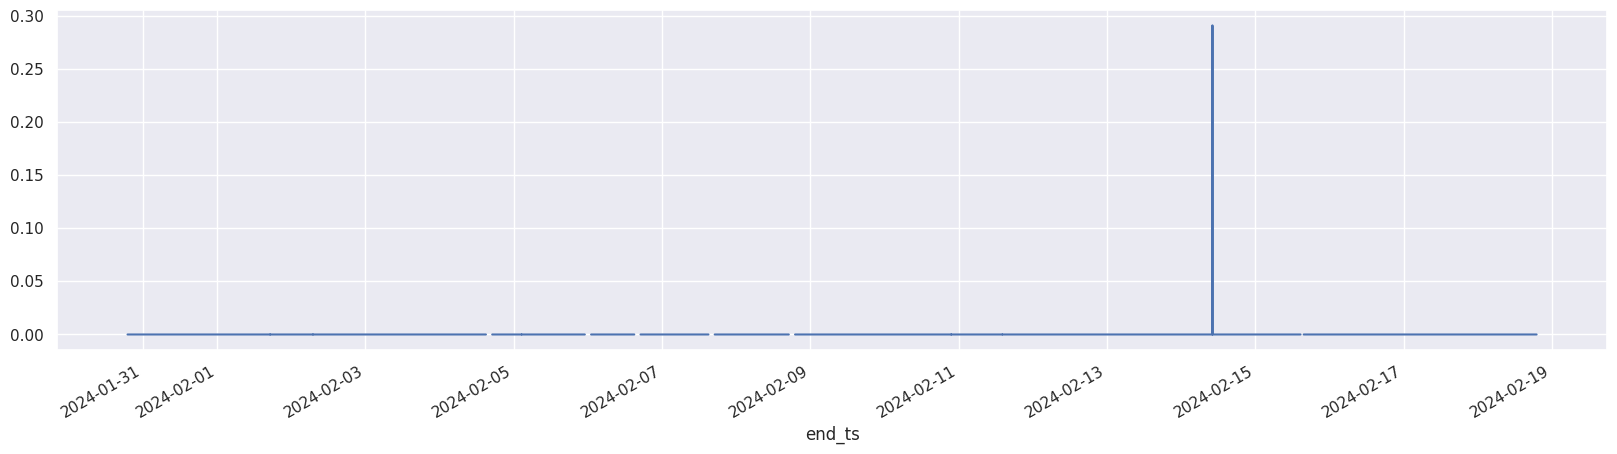

In [75]:
(
    half_spread_bps_df_v1["binance::DUSK_USDT"]
    - half_spread_bps_df_v2["binance::DUSK_USDT"]
).abs().plot()